# Prediction of Customer Review of Women Clothing E-commerce 


##### Import Files and Load Data

In [2]:
# Import files
import os
import numpy as np 
import pandas as pd 
import itertools
from scipy.stats import norm, skew, mode
import re
import gc
import string
import warnings 
import operator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aps20\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aps20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# read dataframe
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

#Find out number of rows & columns in data
print ('Number of (rows,columns): ' + str(df.shape) )

# take a look
df.head()

Number of (rows,columns): (23486, 11)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


##### Basic Data Inspections

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe(include='all')

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,11742.500000,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,6779.968547,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,5871.250000,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,11742.500000,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,17613.750000,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


#### Basic EDA observations 

- Dataset has **23486 rows and 11 columns**. 
- There are a few columns with missing values. All of them are "object" type:
     - Title                    19676 non-null  object
     - Review Text              22641 non-null  object
     - Division Name            23472 non-null  object
     - Department Name          23472 non-null  object
     - Class Name               23472 non-null  object 
- column "unamed" seems to be just row number

#### Data Cleaning

##### Deleting of Missing Values of review text

C:\Users\aps20\AppData\Local\Temp\ipykernel_1528\339275575.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


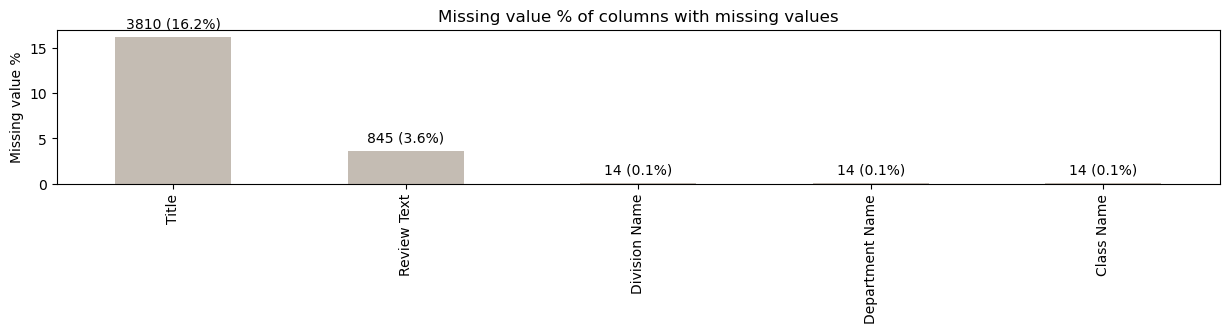

In [6]:
# missing value % and counts
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='#c4bcb3')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value %")
plt.title("Missing value % of columns with missing values")
plt.show()

In [7]:
# Delete rows with missing values in "Review Text"
print("Rows before deleting missing values in review text: ", df.shape[0])
df.dropna(subset=['Review Text'], inplace=True)
print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


##### Filling in missing values for other columns

In [9]:
# Fill in missing values with blank for other columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')
                    
#check if any nulls remained
df.isna().sum().sum()


0

##### Drop useless column

As discussed in initial data inspection, column "unamed" seems to be just row number and can be deleted.

In [8]:
# Drop "Unamed: 0" column
df.drop("Unnamed: 0", axis=1, inplace=True)

##### Drop duplicates

In [9]:
# check duplicates
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


In [10]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


#### Portion of Recommend vs. Not Recommend by Dataset Rows

From the pie chart below, the response data is very imbalanced, and also the minority is the negative samples. This will create problem to train the model. We add more minority classes by resampling method. lets take a look at the distribution of recommended and not recommended counts.

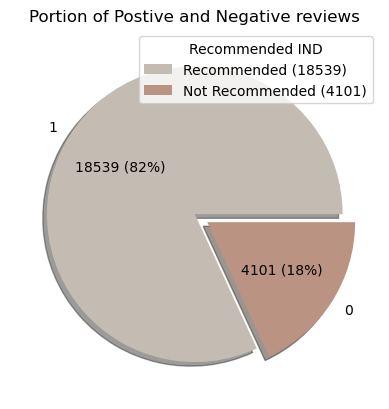

In [11]:
# Plot dependent variable distribution
# parameters for plot
sizes = df['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#c4bcb3', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[1]})", f"Not Recommended ({sizes[0]})"])
plt.show()


##### Combine Text columns

In [14]:
# unique "Title"
len(df.Title.unique())
print(df['Title'].head(10))

0                                        
1                                        
2                 Some major design flaws
3                        My favorite buy!
4                        Flattering shirt
5                 Not for the very petite
6                    Cagrcoal shimmer fun
7    Shimmer, surprisingly goes with lots
8                              Flattering
9                       Such a fun dress!
Name: Title, dtype: object


#### Append 'Title' to 'Review Text'

In [15]:
# Append 'Title' to 'Review Text'
df['Review Text'] = df.apply(lambda row: row['Review Text']  + ' ' + row['Title'], axis=1)

# Drop the "Title" column if it's no longer needed
df.drop(columns=['Title'], inplace=True)


#### Train/Test Split

seperate and analye train and test set seperately. 

In [17]:
# Train/Test Split
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"There are {train.shape[0]} rows in training data")
print(f"There are {test.shape[0]} rows in testing data")

There are 18112 rows in training data
There are 4528 rows in testing data


#### Cleaning of review text and create a new column 'Clean text'

In [30]:
def text_preprocessing(text):
    # convert to lower case
    text = text.str.lower()
    
    # Remove punctuation 
    text = text.apply(lambda doc: re.sub(r'[^\w\s]', '', doc))
    
    # Remove numbers
    text = text.apply(lambda doc: re.sub(r'\d+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda doc: ' '.join([word for word in doc.split() if word not in stop_words]))

    # stemming
    porter_stemmer = PorterStemmer()
    text = text.apply(lambda doc: ' '.join([porter_stemmer.stem(word) for word in word_tokenize(doc)]))
    
    # remove extra spaces
    text = text.apply(lambda doc: re.sub(' +', ' ', doc))

    return text

In [31]:
# Text preprocessing
train['clean_text'] = text_preprocessing(train['Review Text'])
test['clean_text'] = text_preprocessing(test['Review Text'])

In [32]:
# Get X and y df in train and test set
X_train = train.drop(columns=['Recommended IND'])  
y_train =  train['Recommended IND']

X_test = test.drop(columns=['Recommended IND'])  
y_test =  test['Recommended IND']

In [33]:
unique_words_train = len(train['clean_text'].str.split(" ").explode().unique())
print(unique_words_train)

12835


#### Prepare text data for Keras model: Tokenize, Sequence, and Padding

In [26]:
# Tokenizer using Tensorflow Keras

VOCAB_SIZE = unique_words_train #no. of unique words in train set
OOV_TOKEN ="<OOV>" #out-of-vocabulary words

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)

Maximum sequence length: 63


#### Model Building and Training 


 - Model 1: start with a basic Sequential Model with some dense Layers. For embedding, we will use tf build-in embedding, which learn on training data.
 - Model 1 v2: Improve performance of model 1 by simplifying the model.
 - Model (upsampled): based on model 1, discover what resampling would do on Model 1 performance

## Model 1 v1. 

In [140]:
# Build the model
NUM_EPOCHS = 15
BATCH_SIZE = 128
EMBEDDED_DIM =100
MAX_LEN = 120
LEARNING_RATE = 0.0001

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Setup the training parameters
initial_learning_rate = LEARNING_RATE

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])
# Train the model
history_model1 = model1.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7140 - auc: 0.5019 - loss: 0.6043 - precision: 0.8176 - recall: 0.8405 - val_accuracy: 0.8174 - val_auc: 0.5482 - val_loss: 0.4781 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8200 - auc: 0.5845 - loss: 0.4683 - precision: 0.8200 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.7708 - val_loss: 0.4565 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8196 - auc: 0.8254 - loss: 0.4404 - precision: 0.8196 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.9107 - val_loss: 0.3998 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8163 - auc: 0.9315 - loss: 0.3772 - precision: 0.8161 - recall: 0.9997 - val_accuracy: 0.8730 - val_auc: 0.9344 - val_loss: 0.2965 - val_precision: 0.8757 - val_recall: 0.9843
Epoch 5/15
142/142 ━━━━━━━━━

In [141]:
# Plot results function
def plot_results(history, model_name="", early_stopping_callback=None):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    titles = [f'{model_name} Accuracy', f'{model_name} Loss', f'{model_name} Precision', f'{model_name} Recall', f'{model_name} F1 Score']
        
    # Calculate F1 score for training and validation data
    train_precision = history.history['precision']
    train_recall = history.history['recall']
    train_f1_scores = [2 * (train_precision[i] * train_recall[i]) / (train_precision[i] + train_recall[i] + 1e-8)
                   for i in range(len(train_precision))]  # Avoid division by zero
    
    val_precision = history.history['val_precision']
    val_recall = history.history['val_recall']
    val_f1_scores = [2 * (val_precision[i] * val_recall[i]) / (val_precision[i] + val_recall[i] + 1e-8)
                     for i in range(len(val_precision))]  # Avoid division by zero
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        axs[row, col].plot(history.history[metric])
        axs[row, col].plot(history.history[f'val_{metric}'])
        axs[row, col].set_title(titles[i], fontsize=20)  
        axs[row, col].tick_params(axis='both', which='major', labelsize=20)  
        axs[row, col].legend(['Train', 'Validate'], loc='upper left', fontsize=20)

    # Plot F1 score 
    axs[-1, 0].plot(train_f1_scores)
    axs[-1, 0].plot(val_f1_scores)
    axs[-1, 0].set_title(titles[-1], fontsize=20)  
    axs[-1, 0].tick_params(axis='both', which='major', labelsize=20)  
    axs[-1, 0].legend(['Train', 'Validate'], loc='upper left', fontsize=20)
 
    if early_stopping_callback is not None:
        # return best accuracy and corresponding metrics if early stopping
        val_accuracy = history.history['val_accuracy']
        best_index = np.argmax(val_accuracy)
        best_accuracy = val_accuracy[best_index]
        best_precision = val_precision[best_index]
        best_recall = val_recall[best_index]
        best_f1_score = val_f1_scores[best_index]
        return best_accuracy, best_precision, best_recall, best_f1_score
    else:
        # no early stopping callback
        return history.history['val_accuracy'][-1],  val_precision[-1],val_recall[-1],  val_f1_scores[-1]

    plt.tight_layout()
    plt.show()


model 1 accuracy 0.9070229530334473
model 1 precision 0.9347826242446899
model 1 recall 0.9527154564857483
model 1 f1 score 0.9436638468095948


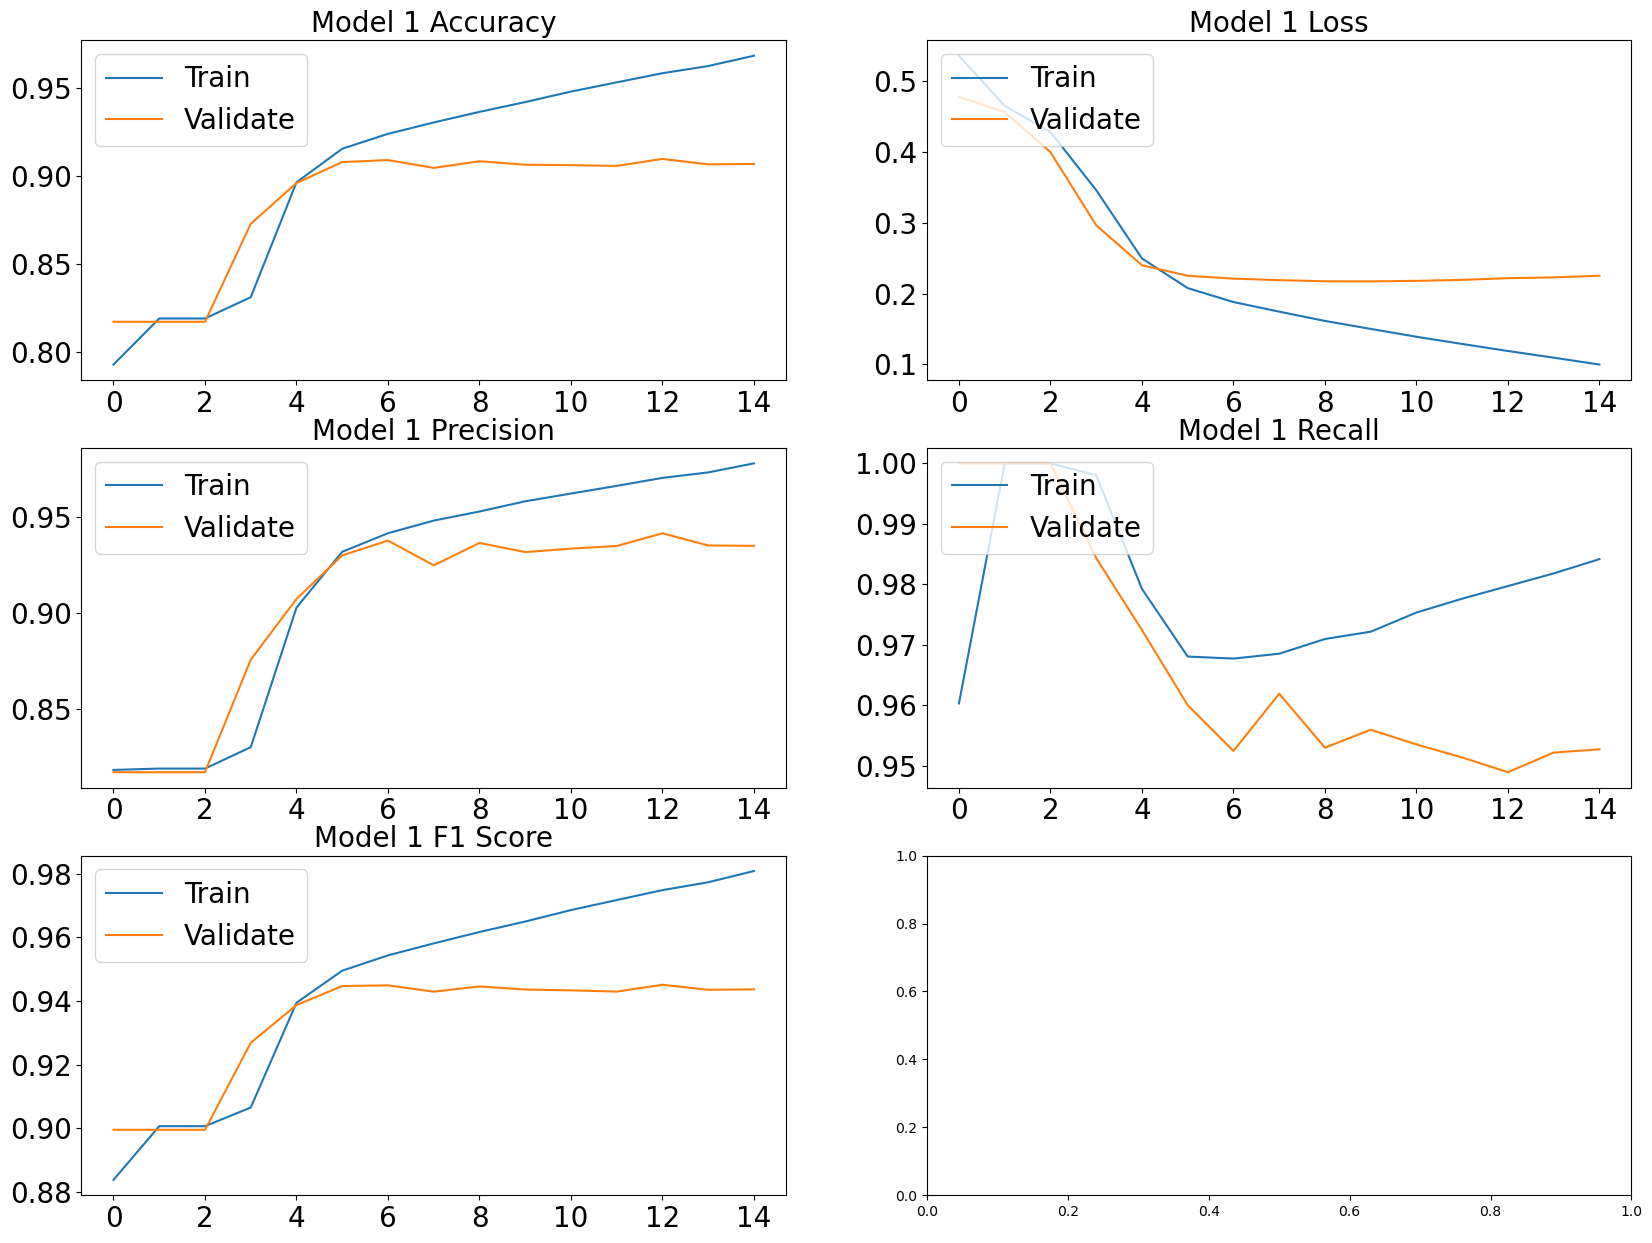

In [142]:
# Plot results
model1_val_accuracy, model1_val_precision, model1_val_recall ,model1_val_f1_scores = plot_results(history_model1,model_name='Model 1' )
print('model 1 accuracy', model1_val_accuracy)
print("model 1 precision", model1_val_precision)
print("model 1 recall",model1_val_recall)
print("model 1 f1 score",model1_val_f1_scores)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 100x100 with 0 Axes>

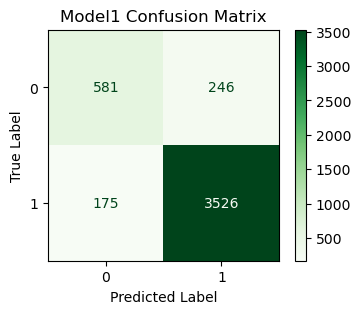

In [143]:
y_pred_model1=plot_cfm(model1,X=padded_test, y_actual= y_test, model_name='Model1')

####  Model 1 (v1.) Performance and Improvement Plan:
It seems the model start to overfit after around 8 epochs - training accuracy is still improving but validation accuracy starts to drop. A few things to help with overfitting:
- Simplify model: for example, less layers, less nodes.
- Add drop out
- train with a little short period.

After several attempts, I find a model with just 1 internal dense layer, adding a dropout layer, and training only with 13 epochs produced the best results.

#### Model 1 (v2.)

In [171]:
# Build the model - less layers, train less
NUM_EPOCHS = 13
BATCH_SIZE = 128
EMBEDDED_DIM =100
MAX_LEN = 120
LEARNING_RATE = 0.0001
DROP_OUT=0.1

model1_v2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Setup the training parameters
initial_learning_rate = LEARNING_RATE

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model1_v2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])
# Train the model
history_model1_v2 = model1_v2.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/13
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7043 - auc: 0.5196 - loss: 0.6332 - precision: 0.7107 - recall: 0.9834 - val_accuracy: 0.8174 - val_auc: 0.6353 - val_loss: 0.4985 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/13
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7129 - auc: 0.6808 - loss: 0.5756 - precision: 0.7129 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.9101 - val_loss: 0.4444 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 3/13
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7277 - auc: 0.9141 - loss: 0.4860 - precision: 0.7236 - recall: 0.9985 - val_accuracy: 0.8874 - val_auc: 0.9353 - val_loss: 0.3286 - val_precision: 0.8964 - val_recall: 0.9749
Epoch 4/13
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8589 - auc: 0.9410 - loss: 0.3505 - precision: 0.8528 - recall: 0.9708 - val_accuracy: 0.9026 - val_auc: 0.9412 - val_loss: 0.2672 - val_precision: 0.9263 - val_recall: 0.9570
Epoch 5/13
163/163 ━━━━━━━━━

model 1 accuracy 0.9098939895629883
model 1 precision 0.9413025975227356
model 1 recall 0.9489327073097229
model 1 f1 score 0.9451022475940737


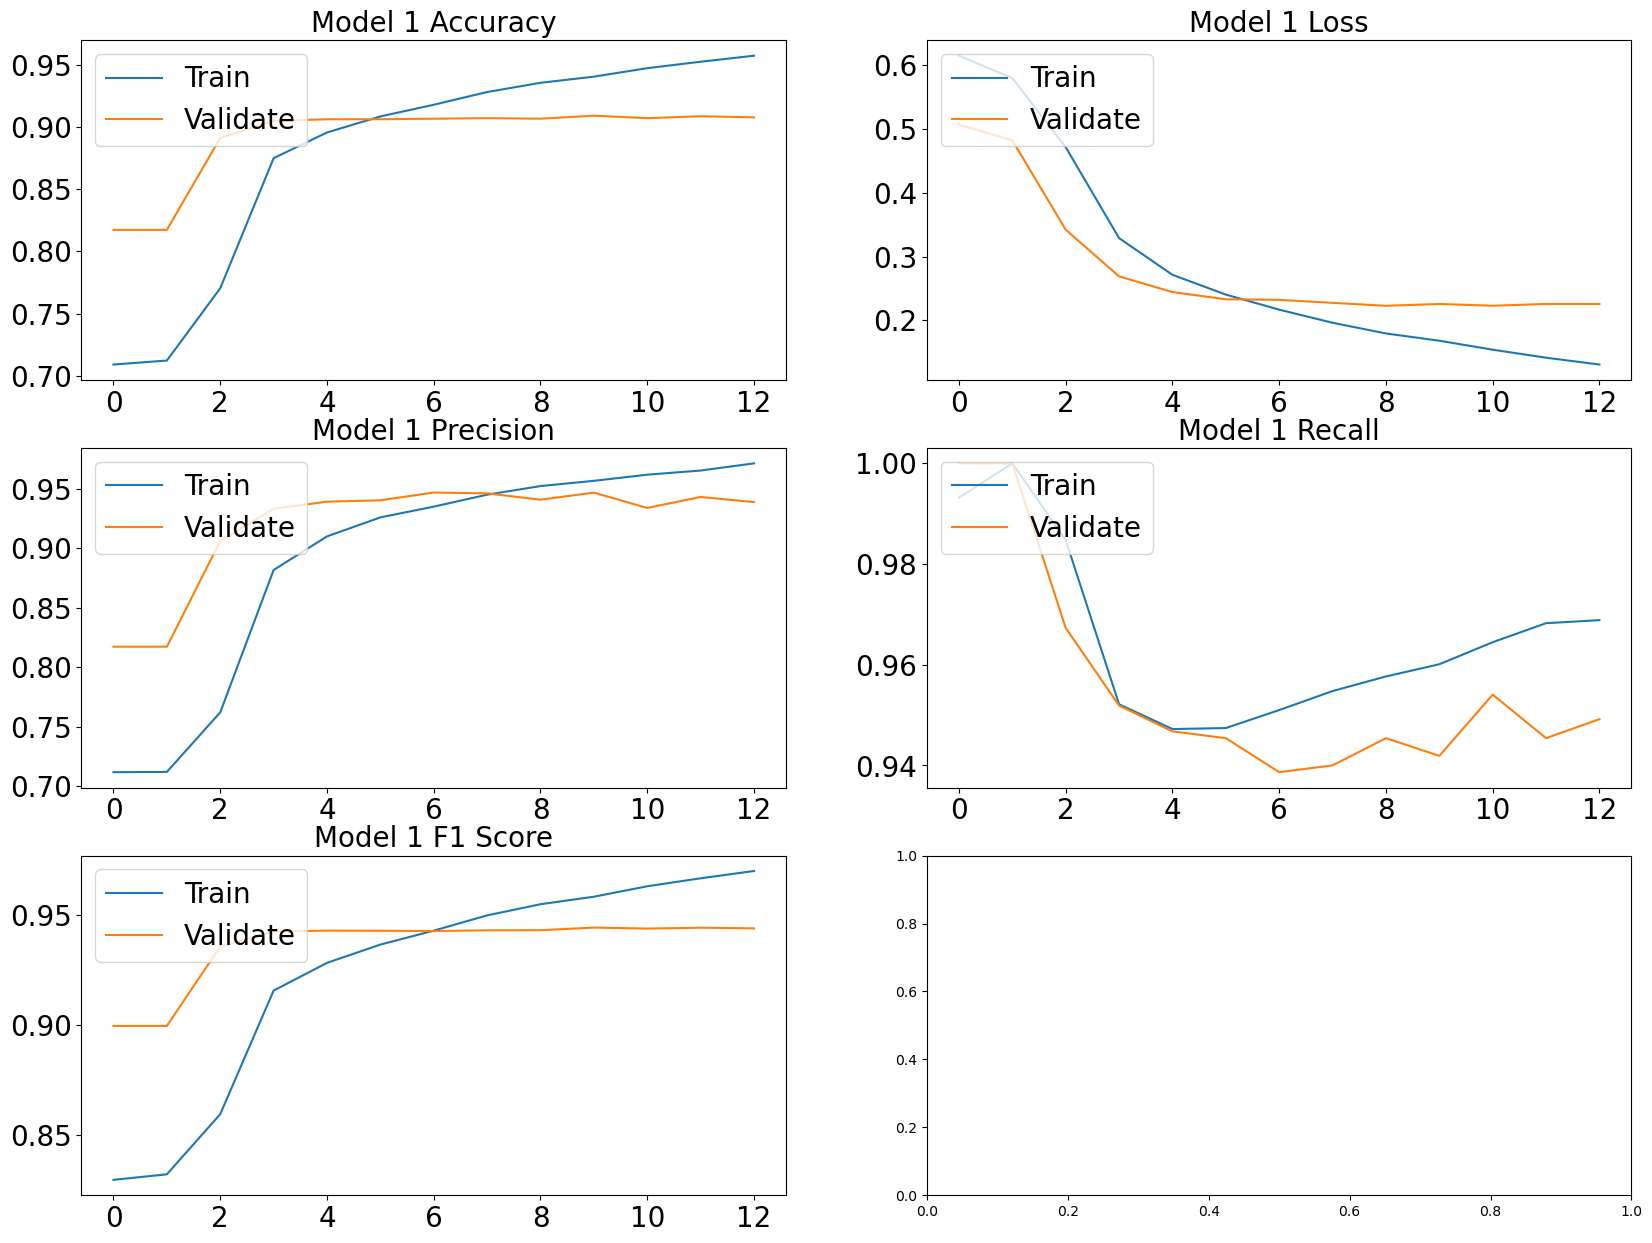

In [172]:
# Plot results
model1_v2_val_accuracy, model1_v2_val_precision, model1_v2_val_recall ,model1_v2_val_f1_scores = plot_results(history_model1_2,model_name='Model 1' )
print('model 1 accuracy', model1_val_accuracy)
print("model 1 precision", model1_val_precision)
print("model 1 recall",model1_val_recall)
print("model 1 f1 score",model1_val_f1_scores)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 100x100 with 0 Axes>

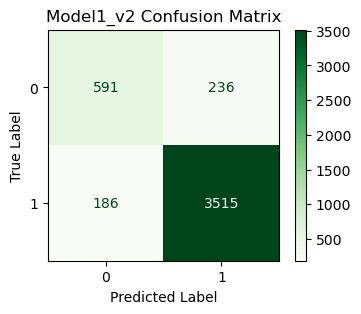

In [176]:
y_pred_model1_v2=plot_cfm(model1_v2,X=padded_test, y_actual= y_test, model_name='Model1_v2')

## Resampling
To address the class imbalance in our dataset, we will upsample the minority class (negative comments). 

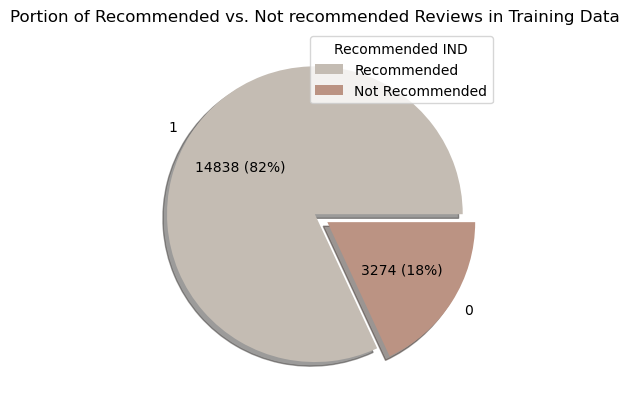

In [144]:
#Plot dependent variable distribution in training set 
#parameters for plot
sizes = train['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#c4bcb3', '#bb9383'] 
# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Recommended vs. Not recommended Reviews in Training Data')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended", f"Not Recommended"])
plt.show()

In [145]:
# Resampling  in training set - upsampling
#create two different dataframe of majority and minority class 
train_minority = train[(train['Recommended IND']==0)] 
train_majority = train[(train['Recommended IND']==1)] 

# Upsample minority class
train_minority_upsampled = resample(train_minority,
                                    replace=True,  
                                    n_samples=6000,  
                                    random_state=100)

train = pd.concat([train_minority_upsampled, train_majority])
train = train.sample(frac=1, random_state=100)

Positive and Negative Recommended Reviews in training data: 
 Recommended IND
1    14838
0     6000
Name: count, dtype: int64


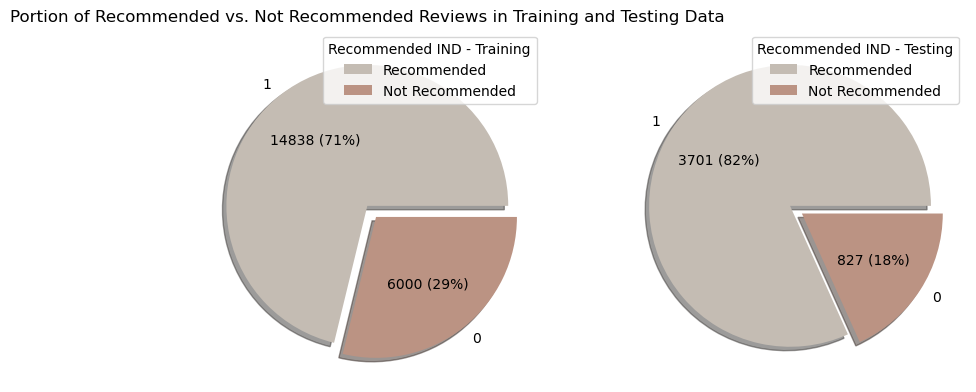

In [146]:
# Plot dependent variable distribution in training and testing set 
# parameters for plot
sizes_train = train['Recommended IND'].value_counts()
sizes_test = test['Recommended IND'].value_counts()
print('Positive and Negative Recommended Reviews in training data: \n',sizes_train)
# Pie chart
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.pie(x=sizes_train, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes_train) / 100, p), colors=colors)
plt.title('Portion of Recommended vs. Not Recommended Reviews in Training and Testing Data')
plt.legend(title="Recommended IND - Training", loc="upper right", labels=[f"Recommended", f"Not Recommended"])

plt.subplot(1, 2, 2)
plt.pie(x=sizes_test, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes_test) / 100, p), colors=colors)
plt.legend(title="Recommended IND - Testing", loc="upper right", labels=[f"Recommended", f"Not Recommended"])
plt.show()

## Tokenize, Sequence, and Padding again after Resampling

In [155]:
# Get X and y df in train and test set
X_train= train.drop(columns=['Recommended IND'])  
y_train =  train['Recommended IND']

X_test = test.drop(columns=['Recommended IND'])  
y_test =  test['Recommended IND']

In [156]:
# Tokenizer using Tensorflow Keras
VOCAB_SIZE = unique_words_train # unique words in training set
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length= max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)

Maximum sequence length: 63


In [157]:
print(f"Shape of padded_train: {padded_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of padded_train: (20838, 63)
Shape of y_train: (20838,)


## Fit model 2 

For parameters, after several attemps, I find:
- As usual, have drop out layers to help with overfitting. But drop out rate need to be low or otherwise the model won't learn well.
- After upsampling, the model tends to overfit more. However, increase drop out would prevent the model to learn best. I find have a bit less epochs work the best to help with overfitting.


In [159]:
# Build the model
NUM_EPOCHS = 10
BATCH_SIZE = 128
EMBEDDED_DIM =100
LEARNING_RATE = 0.0001
DROP_OUT=0.1

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(DROP_OUT),
#     tf.keras.layers.Dense(12, activation='relu'),
#     tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])

In [160]:
# Train the model
history_model2 = model2.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6731 - auc: 0.5096 - loss: 0.6397 - precision: 0.7158 - recall: 0.9079 - val_accuracy: 0.8174 - val_auc: 0.5914 - val_loss: 0.5121 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7182 - auc: 0.6158 - loss: 0.5840 - precision: 0.7182 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.8389 - val_loss: 0.4724 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7299 - auc: 0.8482 - loss: 0.5129 - precision: 0.7279 - recall: 0.9929 - val_accuracy: 0.8907 - val_auc: 0.9327 - val_loss: 0.3445 - val_precision: 0.9026 - val_recall: 0.9711
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8670 - auc: 0.9364 - loss: 0.3533 - precision: 0.8697 - recall: 0.9578 - val_accuracy: 0.9019 - val_auc: 0.9407 - val_loss: 0.2785 - val_precision: 0.9379 - val_recall: 0.9424
Epoch 5/10
163/163 ━━━━━━━━━

model (after upsample) accuracy 0.9109982252120972
model (after upsample) precision 0.9432795643806458
model (after upsample) recall 0.9481221437454224
model (after upsample) f1 score 0.9456946498049179


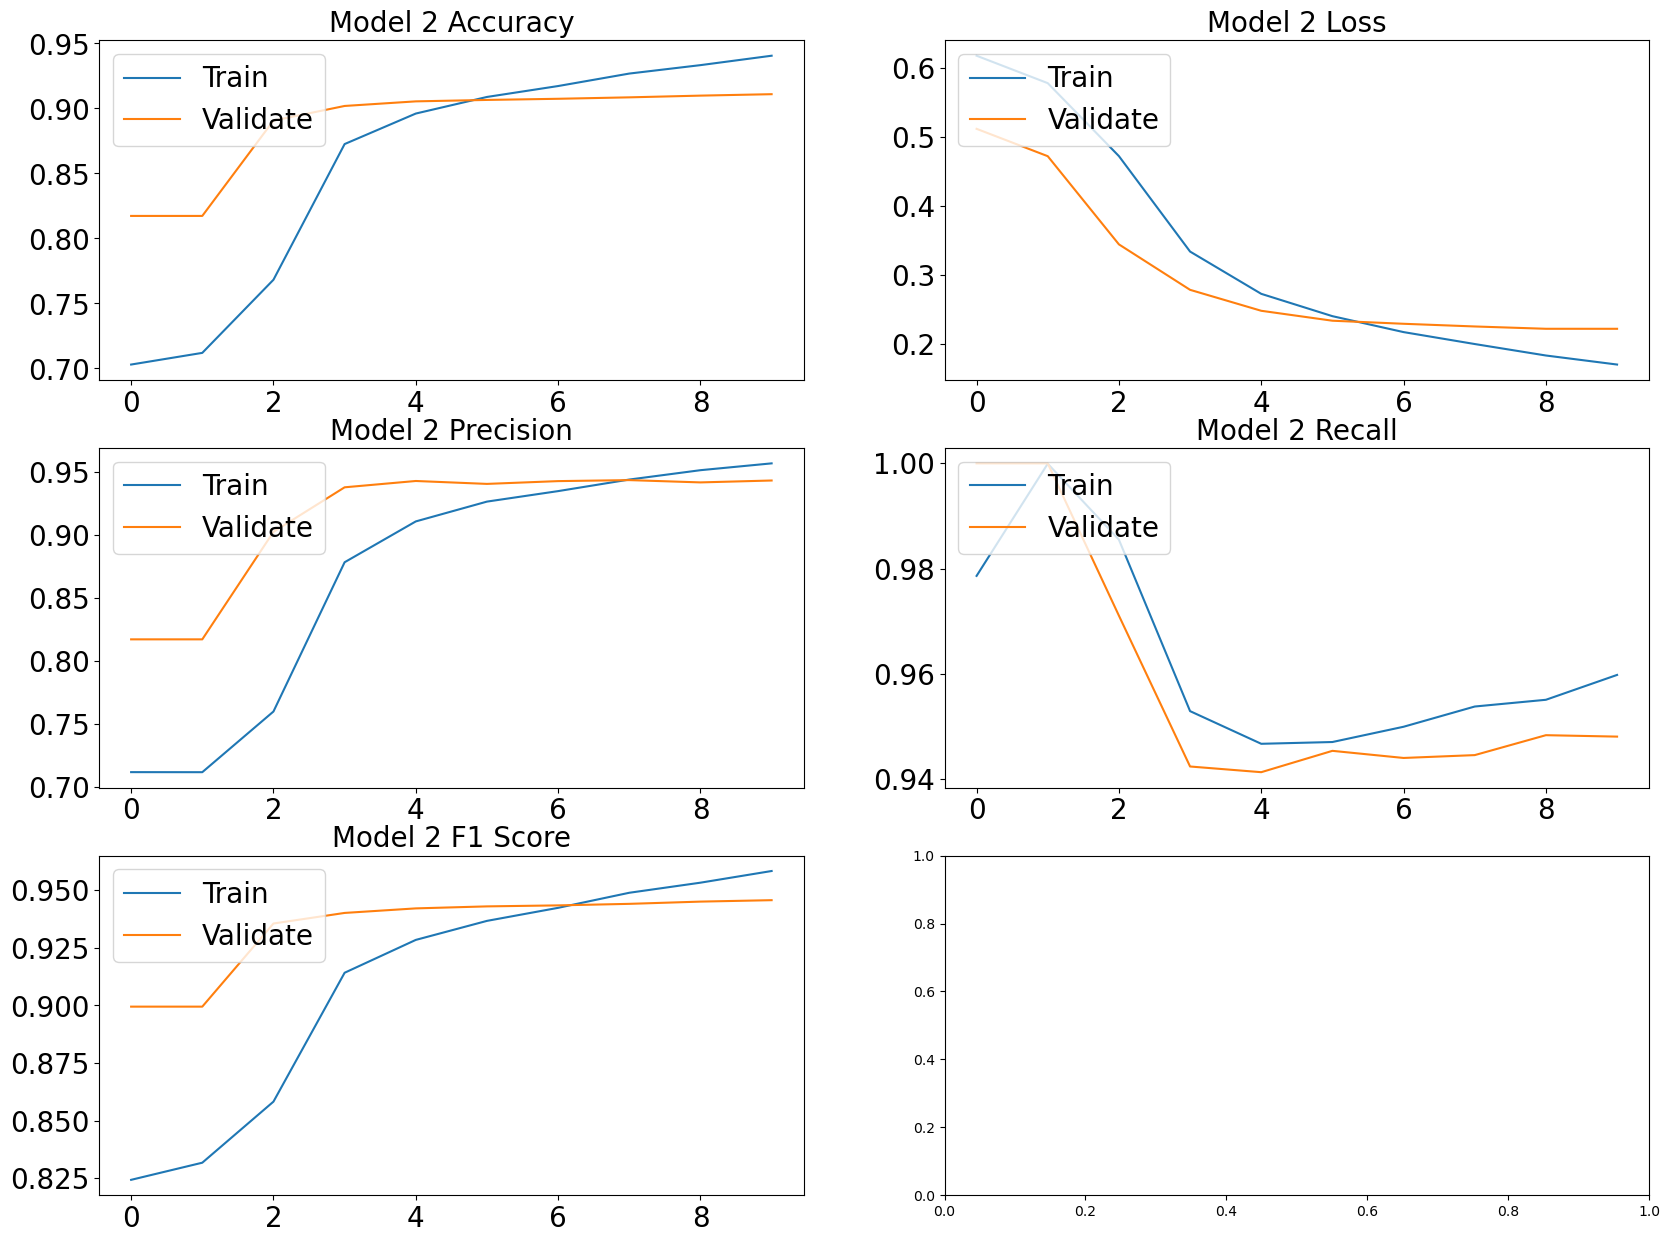

In [161]:
# Plot results
model2_val_accuracy, model2_val_precision, model2_val_recall ,model2_val_f1_scores = plot_results(history_model2,model_name='Model 2' )
print('model (after upsample) accuracy', model2_val_accuracy)
print("model (after upsample) precision", model2_val_precision)
print("model (after upsample) recall",model2_val_recall)
print("model (after upsample) f1 score",model2_val_f1_scores)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 100x100 with 0 Axes>

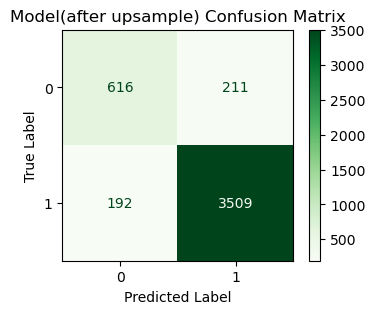

In [162]:
y_pred_model2=plot_cfm(model2,X=padded_test, y_actual= y_test, model_name='Model(after upsample)')

In [163]:
# Take a look at false positive, false negative Recommended Text
# function
def fp_fn_look(y_pred_model):
        fp_indices = np.where((np.array(y_pred_model)== 1) & (y_test == 0))[0]
        fn_indices = np.where((np.array(y_pred_model)== 1) & (y_test == 1))[0]

        # False positive
        print('****************************** Not recommended text predicted as recommended (False Positive) ***********************************')
        indices = np.random.choice(fp_indices,2, replace=False)
        for i in indices:
            print(f'text{i}\n', X_test.iloc[i]['clean_text'],'\n' )

        #  False negative
        print('****************************** Recommended Text predicted as not recommended (False Negative) ***********************************')
        indices = np.random.choice(fn_indices,2,replace=False)
        for i in indices:
            print(f'text{i}\n',X_test.iloc[i]['clean_text'] )
            
#model  fp, fn samples
fp_fn_look(y_pred_model2)

****************************** Not recommended text predicted as recommended (False Positive) ***********************************
text2398
 good way everywher went left littl sweater behind within hour pick ball fabric couch bed sweater look like molt great style fabric fit although littl long side there way keep sweater everywher 

text145
 love color style sweater eager wear ive done two occas im concern qualiti also wonder long version sweater shorter version thin sweater doesnt hit mid thigh goe upper thigh measur length sweater rather seem indic shorter length model wish longer problem fuzzi pa two version 

****************************** Recommended Text predicted as not recommended (False Negative) ***********************************
text1397
 great jean great cut great fit love distress look rise higher thought dealbreak typic wear brand jean got perfect
text214
 true size take account brand make thing bigger hte size order xx xs xx flatter year past xx would way snug size didn

             Model   Model  (upsampled)
Metric                                 
Accuracy   0.909894            0.910998
Precision  0.941303            0.943280
Recall     0.948933            0.948122
F1 Score   0.945102            0.945695


<Figure size 1000x500 with 0 Axes>

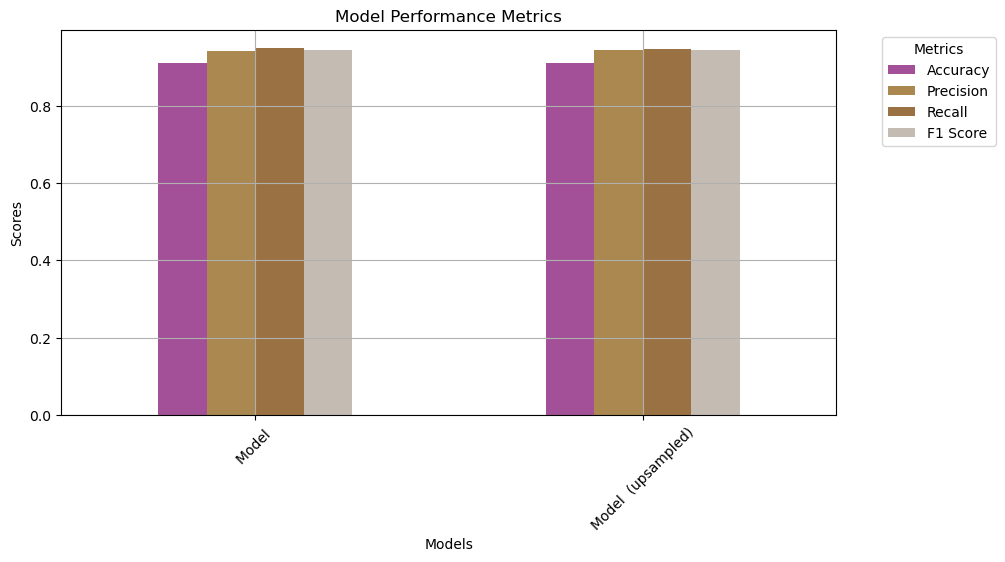

In [178]:
# Models' summary
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Model ": [model1_val_accuracy, model1_val_precision, model1_val_recall, model1_val_f1_scores],
    "Model  (upsampled)": [model2_val_accuracy, model2_val_precision, model2_val_recall, model2_val_f1_scores],
    
    
 
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Metric", inplace=True)
print(metrics_df)


# Plot the data
colors = ['#a35098', '#aa884f','#9a7142','#c4bcb3']
plt.figure(figsize=(10, 5))
metrics_df.T.plot(kind='bar', figsize=(10,5), color=colors)

plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 100x100 with 0 Axes>

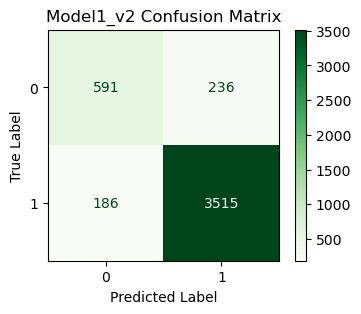

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 100x100 with 0 Axes>

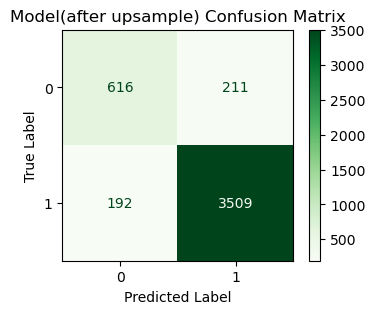

In [177]:
y_pred_model1_v2=plot_cfm(model1_v2,X=padded_test, y_actual= y_test, model_name='Model1_v2')
y_pred_model2=plot_cfm(model2,X=padded_test, y_actual= y_test, model_name='Model(after upsample)')

#### Model 2 Performance and Next Model Plan:
- It seems model 2 overall performance is similar to model 1. There was a noticeable shift in the distribution of false positives and false negatives. Specifically, upsampling the minority class led to a more balanced distribution, with a reduction in false positives and an increase in false negatives. 

- This indicates that upsampling helps address the class imbalance in the predictions. However, it's important to note that while reducing false positives, the number of false negatives may increase so the metrics focusing on overall performance (such as F1 score, accuracy) won't improve afer re-sampling. But, if the goal is to lower the false positive rate, upsampling can be beneficial, but one must be mindful of the trade-off with false negatives.

